<a href="https://colab.research.google.com/github/ElioRame/ProgrammingAssignment2/blob/master/FinalPALS0039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# All seven books are used for the assignments, they are downloaded using read.lines() from library and renamed
with open("/content/pg74.txt") as TomSawyer:
  Book1 = TomSawyer.readlines()
with open("/content/pg84.txt") as Frankenstein:
  Book2 = Frankenstein.readlines()
with open("/content/pg345.txt") as Dracula:
  Book3 = Dracula.readlines()
with open("/content/pg1342.txt") as PrideandPrejudice:
  Book4 = PrideandPrejudice.readlines()
with open("/content/pg1727.txt") as Odissey:
  Book5 = Odissey.readlines()
with open("/content/pg2701.txt") as MobyDick:
  Book6 = MobyDick.readlines()
with open("/content/pg3207.txt") as Leviathan:
  Book7 = Leviathan.readlines()

# They are then added together to create a new list named 'data'
data = Book1 + Book2 + Book3 + Book4 + Book5 + Book6 + Book7
print(data[:50])

['\ufeffThe Project Gutenberg eBook of The Adventures of Tom Sawyer, Complete\n', '    \n', 'This ebook is for the use of anyone anywhere in the United States and\n', 'most other parts of the world at no cost and with almost no restrictions\n', 'whatsoever. You may copy it, give it away or re-use it under the terms\n', 'of the Project Gutenberg License included with this ebook or online\n', 'at www.gutenberg.org. If you are not located in the United States,\n', 'you will have to check the laws of the country where you are located\n', 'before using this eBook.\n', '\n', 'Title: The Adventures of Tom Sawyer, Complete\n', '\n', 'Author: Mark Twain\n', '\n', 'Release date: July 1, 2004 [eBook #74]\n', '                Most recently updated: August 9, 2023\n', '\n', 'Language: English\n', '\n', 'Credits: David Widger\n', '\n', '\n', '*** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF TOM SAWYER, COMPLETE ***\n', '\n', '\n', '\n', '\n', 'THE ADVENTURES OF TOM SAWYER\n', '\n', '\n', '

In [6]:
!pip install -U nltk>=3.7.0

import nltk


nltk.download("punkt")
nltk.download('punkt_tab')
# NLTK library will be mainly used to pre-process the data to create a vocabulary of tokens and create the corpus
from nltk.lm import Vocabulary
from nltk.util import pad_sequence
from nltk.tokenize import RegexpTokenizer
from nltk.lm.preprocessing import flatten

# matplotlib will be used to show the loss and perplexity values for the model
import matplotlib.pyplot as plt
# the following code is used so that the plots do not appear in a separate window
%matplotlib inline

import numpy as np
import regex as re

# tensorflow library will be used to create the model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
import string
import collections
import operator
import unicodedata

# Check whether non-Latin alphabet characters are present in the data
# Eliminate non-English characters and punctuation by first defining a function that identifies, using booleans, whether
# all characters are alphabetical and part of the Latin alphabet script in the unicodedata function
# This function also preserves common occurring symbols that are not part of the Latin alphabet (i.e. currency)
def is_english_letter(letters):
  return str(letters).isalpha() and unicodedata.name(letters).startswith(('LATIN', 'COMMON'))

# Check if present data contains only letters that are part of the Latin alphabet
unwanted_letters = []
for sentence in data:
  for letter in sentence:
   if is_english_letter(letter) == False:
    unwanted_letters.append(letter)
print("Are all letters in the raw text part of the Latin alphabet?", is_english_letter(data))
print("Non-Latin letters in raw text:", set(unwanted_letters))

# There are characters belonging to different alphabets
# Process the dataset to eliminate unwanted characters
# if the item is part of the latin alphabet it is added to a new list
def remove_non_english_letters(data):
    english_list = []
    for letter in data:
        filtered = filter(is_english_letter, list(letter))
        english_string = "".join(filtered)
        english_list.append(english_string)

    return english_list

# Create a list to append the padded and processed text
letters = []



for text in data:
  # Every item in the list is a sentence in the text, split at every period
  split_text = text.split(".")
  for sentence in split_text:
   # The following code creates a new list. For all the sentences in the text, all letters are made lowercase
   # This creates a new list of lists with every letter in every list forming a separate token
     lower_text = [letter.lower() for letter in sentence]
   # All letters that don't belong to the English alphabet are removed, including punctuation
     eng_text = remove_non_english_letters(lower_text)
   # The corpus is padded at the sentence level by using <s> at the start, and </s> at the end, of every sentence
     padded_corpus = list(pad_sequence(eng_text, n=2, pad_left=True, left_pad_symbol="<s>", pad_right=True, right_pad_symbol="</s>"))
   # The padded corpus is appended to the list "letters"
     letters.append(padded_corpus)


# The corpus is flattened to create a single list with all padded sentences
corpus = list(flatten(letters))


# A vocabulary is created using nltk.vocab which gives us a list of all the letters that appear in the text for 50 times or more
vocab = Vocabulary(corpus, unk_cutoff=50)

# Data from the corpus is partitioned into train and test sets
test_letters = corpus[:100000]
train_letters = corpus[100000:]

# Check if foreign letters were successfully excluded
latin_false  = []
for i in corpus:
  if is_english_letter(i) == False:
    latin_false.append(i)
print("Non-Latin letters in processed text:", set(latin_false), "\n")

# Inspect corpus
print("Inspect corpus:", corpus[:25])
print("Length of corpus:", len(corpus), "\n")

# Inspect which letters are part of the corpus, but not the vocabulary
# There are 31 vocab words, consistent with the English alphabet with
# added '<UNK>' and padding, as well as empty spaces between words
print("Unique letters:", set(corpus))
print("Length of unique letters in corpus:", len(set(corpus)), "\n")

show_vocab = [i for i in vocab]
print("Vocabulary:", show_vocab)
print("Length of vocabulary:", len(vocab), "\n")

# Inspect which letters have been excluded by the vocabulary
# No common English alphabet letter was excluded by the cutoff parameter of 50
for i in set(corpus):
    discarded_letters = [i for i in set(corpus) if i not in vocab]
print("Discarded letters:", discarded_letters)



Are all letters in the raw text part of the Latin alphabet? False
Non-Latin letters in raw text: {'ί', '3', 'μ', '%', 'ύ', 'ε', '•', '8', 'ἠ', ';', 'ι', '£', 'γ', 'ἐ', '#', 'ν', '(', 'χ', '?', 'υ', 'λ', 'ἄ', '_', 'ῶ', 'ו', '’', '™', 'ς', 'ῖ', '&', 'ο', 'δ', '—', '9', '^', 'ό', 'ἔ', 'ῆ', 'τ', '.', '/', '!', '0', 'η', 'ὶ', 'ῥ', '"', 'έ', 'ח', '4', 'ὼ', ':', '*', 'ἦ', '6', '“', 'ζ', 'ῳ', 'ῇ', ']', ',', 'σ', 'ἀ', 'ὺ', 'ὦ', 'κ', '$', '‘', 'θ', 'ἷ', '1', 'π', 'ἰ', '}', 'Ν', 'Μ', 'ή', '-', '2', 'ὡ', ')', 'ὀ', 'ώ', '”', 'φ', 'Ἰ', 'ὄ', '{', 'ϰ', 'ω', ' ', 'ρ', '\ufeff', '·', '\n', 'ά', '5', '7', '[', 'α'}
Non-Latin letters in processed text: {'', '</s>', '<s>'} 

Inspect corpus: ['<s>', '', 't', 'h', 'e', '', 'p', 'r', 'o', 'j', 'e', 'c', 't', '', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', '', 'e']
Length of corpus: 5884806 

Unique letters: {'', 'h', 'n', 's', 'p', 'm', 'g', 'œ', 'x', 'z', 'é', 'e', '<s>', 'ô', 'ê', 'j', 'r', 'á', 't', 'ù', 'o', 'v', 'i', 'ö', 'q', 'w', 'd', 'c', '</s>', 'æ'

In [11]:
# Create a dictionary that maps letters to their indexes within the vocab.
# We iterate though the words in our vocabulary and assign an index to each one
# The index then becomes the key value to our letter
letter_to_index = {l: i for i, l in enumerate(vocab)}



# We iterate through all the letters in the training and test sets and convert each letter
# to the index using the letter_to_index dictionary
# The lookup function will return the correct index for each letter
train_indices = [letter_to_index[vocab.lookup(l)] for l in train_letters]
test_indices = [letter_to_index[vocab.lookup(l)] for l in test_letters]

# A list of indexes can then be fed to the neural network
print(train_indices[:25])
print(test_indices[:25])




[4, 1, 24, 0, 2, 21, 7, 1, 3, 4, 16, 17, 19, 1, 13, 7, 21, 4, 17, 1, 2, 7, 10, 4, 2]
[0, 1, 2, 3, 4, 1, 5, 6, 7, 8, 4, 9, 2, 1, 10, 11, 2, 4, 12, 13, 4, 6, 10, 1, 4]


In [12]:
# Choose sequence length
seqlen = 80

# we create a function which takes the input, an index value, and the sequence length as arguments
# We create sequences of same length by using the modulo (%) which divides our input into 80 letter
# sequences while the remainder is discarded
def prepare_sequences(letters, unk_index, seqlen=seqlen):
  # We calculate the remainder of our corpus length divided by the chosen sequence length
  trunc_length = len(letters) % seqlen
  # We create a two dimentional array of shape (, 80) by taking away the trunc_length remainder
  # from the start of the corpus
  X = np.array(letters)[trunc_length:].reshape((-1, seqlen))
  # Similarly, a (, 80) dimensional array is created for the corpus with the added unk_index by taking away the remainder
  # from the start of the corpus
  # The output is shifted by 1, with unk_index representing the next letter to predict.
  y = np.array(letters + [unk_index])[trunc_length + 1:].reshape((-1, seqlen))
  return X, y

# The unk_index is set to the vocabulary index for "<UNK>"
Xtrain, ytrain = prepare_sequences(train_indices, letter_to_index["<UNK>"])
Xtest, ytest = prepare_sequences(test_indices, letter_to_index["<UNK>"])


print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)




(72310, 80) (72310, 80)
(1250, 80) (1250, 80)


In [33]:
# This function calculates the degree of uncertainty with which the model makes the prediction for the next letter
def perplexity(y_true, y_pred):
  cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = tf.exp(tf.reduce_mean(cross_entropy))
  return perplexity

# A sequential model is built with vocab length as input and output width, 80 as input length, and 0.01 learning rate
def build_model(input_width=len(vocab), input_length=seqlen, output_width=len(vocab), learning_rate=0.01):
 model = Sequential()

 # The Embedding layer transforms each input into a unique vector of length output_dim
 # Through the unique vectors the model learns relationships between the inputs
 model.add(Embedding(input_dim=input_width, output_dim=128, input_length=seqlen))

 #The following LSTM uses the vectors to learn the sequences and returns a hidden state output for each input time step
 model.add(LSTM(32, return_sequences=True, activation='tanh'))

 # A dropout layer takes the output and turns 20% of the weights to zero to avoid overfitting
 model.add(Dropout(0.2))

 # A second LSTM model returns an output at each time step to be fed to a fully connected layer
 model.add(LSTM(32, return_sequences=True, activation='tanh'))

 # The dense layer calculates the probability of nect letter using softmax
 # Sparse categorical crossentropy to convert the index labels to one hot encoded format before calculating loss
 # The Adam optimiser was used for its efficiency in dealing with sparse and noisy data and adaptive learning rates
 # Perplexity was chosen to show how well the model is able to predict the next letter
 model.add(TimeDistributed(Dense(output_width, activation='softmax')));
 model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=[perplexity])
 return model

LSTMmodel = build_model()




In [21]:
# model.fit is used on the training data.
# Twenty percent of the training data is used for validation
# the remaining amount is plit into 452 batches of 218 sequences each, which are trained for 90 epochs.
# EarlyStopping is part of the tensorflow package, it will monitor a specific value (in this case, 'val_loss')
# it will stop if there has been no meaningful change for ten epochs
# This helps to avoid overfitting
training_model = LSTMmodel.fit(Xtrain,ytrain, batch_size=128, validation_split=0.20, epochs=90, callbacks=EarlyStopping(monitor="val_loss", patience=5), verbose = 0)

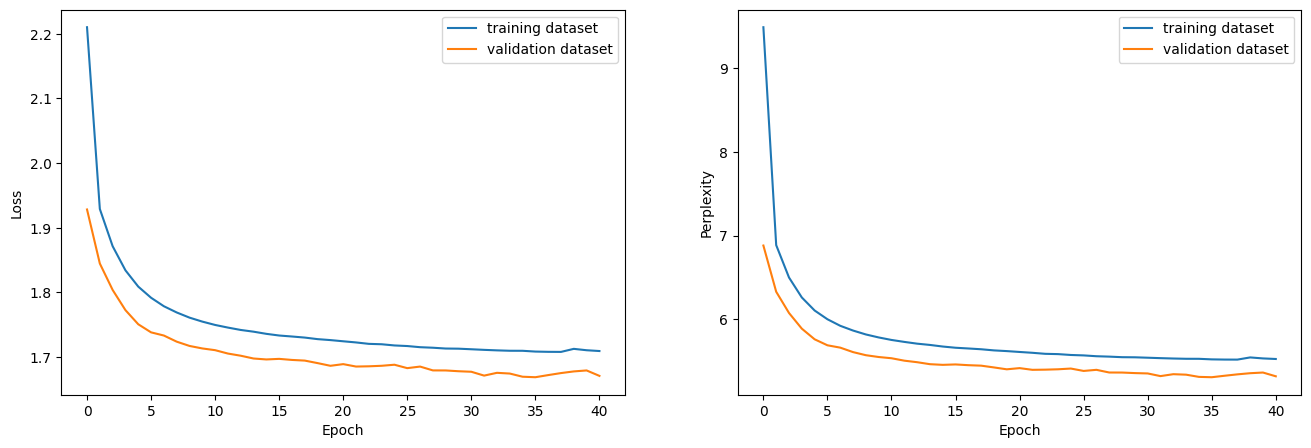

In [29]:
# Make two graphs, plotting respectively the Loss and Perplexity values

def plot_training_history(training_model):
  # Choose the number of plots, how they should appear (side to side), and the size of the final figure
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  # Plot 1: Loss - plot a line graph for both the training and validation set values throughout
  # the different epochs ('loss' and 'val_loss') in training_info
  axs[0].plot(training_model.history['loss'], label="training dataset")
  axs[0].plot(training_model.history['val_loss'], label="validation dataset")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].legend()
  # Plot 2: Perplexity - plot a line graph for both the training and validation set values
  # throughout the different epochs
  axs[1].plot(training_model.history['perplexity'], label="training dataset")
  axs[1].plot(training_model.history['val_perplexity'], label="validation dataset")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Perplexity")
  axs[1].legend()

  plt.show()

plot_training_history(training_model)

In [24]:
# Calculate loss and perplexity
test_loss, test_perplexity = LSTMmodel.evaluate(Xtest, ytest, verbose=0)
print("Test loss:", test_loss)
print("Test perplexity:", test_perplexity)

Test loss: 1.6998599767684937
Test perplexity: 5.47928524017334


In [28]:
# Map indexes stored through word_to_index() back to their original form
index_to_letter = {i: l for l, i in letter_to_index.items()}

# Choose seed text
seed_text = "<s> Happy birth"
# Choose how many characters you want the model to predict
next_letters = 3
# Create a list to add the tokenised and padded seed_text
sequence = []

# Lower, tokenise, and remove punctuation from seed_text
for text in seed_text:
  lower_t = [word.lower() for word in seed_text]
  for words in lower_t:
   tokenizer = RegexpTokenizer(r'\w+')
   token_word = tokenizer.tokenize(words)
   for word in token_word:
    for letter in word:
      sequence.append(letter_to_index[letter])

# Pad the sequence
padded_seq = pad_sequences([sequence], maxlen = len(sequence), padding = "post")

# Use model.predict to estimate how likely it is for each letter in the vocabulary to come after the seed_text
for i in range(next_letters):
  full_prediction = LSTMmodel.predict(padded_seq, verbose=0)
  next_three_letters = full_prediction[0][len(padded_seq) + i]
  # Use np.argmax to obtain the letter with the highest probability amongst the vocabulary items
  prediction = index_to_letter[np.argmax(next_three_letters)]
  # Add each prediction to the seed_text
  seed_text += prediction


# Print sequence
print("Next_three_letters:", seed_text)

Next_three_letters: <s> Happy birther


1.	Data pre-processing

The present notebook makes use of all the seven texts made available for this assignment; namely: "The Adventures of Tom Sawyer" (Book 1), "Frankenstein" (Book 2), "Dracula" (Book 3), "Pride and Prejudice"(Book 4), "The Odyssey" (Book 5), "Moby Dick" (Book 6), and "Leviathan" (Book 7). The pre-processing of the data and building of the model was facilitated by the use of the NLTK and Tensorflow libraries.
Upon inspection of the dataset, it became clear that the corpus contained letters belonging to non-Latin alphabets. Given the nature of the assignment - which required to build a language model able to predict the next three letters in a given English seed text - the data was pre-processed to include only letters that are part of the Latin alphabet by creating a new list which only comprised tokens present in the unicodedata dataset under the “LATIN” and “COMMON” code. The text was first tokenised. After eliminating foreign alphabet characters, the tokens were padded at the start and at the end of each sequence. A single flattened list was then created with each letter from the corpus forming a separate item. The empty spaces between words were kept, as they provided the model with useful information about the way in which different letters unfold into sequences of words, which may lead to a higher rate of correct predictions.

Using the nltk.lm.Vocabulary class, a list containing every letter present more than 50 times throughout the corpus was made. Analysis of the final dataset revealed a total length of 5884806 letters; a vocabulary set of 31 letters, which, upon inspection, included all letters of the English alphabet, as well as both designed chosen padding symbols (“< s>” and “< /s>”); while the total length of unique letters in the text was found to be 43, containing letters whose frequency was deemed to low to be relevant for the task ('ö', 'á', 'í', 'â', 'é', 'œ', 'à', 'ê', 'ù', 'ï', 'ë', 'ô', 'è'). Finally, the list was separated into a training set, which comprised all the letters in the corpus apart of the first 100000, which were selected to be used for the test set.

The aim of the neural network will be to predict which letter from the vocabulary is more likely to follow a text sequence - to this end, an index was then created to obtain a numerical equivalent of each letter in the list based on their position in the vocabulary. After indexing the train and test sets, the data was reshaped into an array by partitioning each set into arrays of shape (, 80) to obtain sequences of similar length: the training set, of dimension (70468, 80), and the test set, of dimension (1250, 80). An 80/20 split between the training and validation test was chosen for training over 90 epochs, with EarlyStopping being set at 5 to avoid overfitting - the model will monitor the loss function for the validation set and stop if the gradient descent has not decreased for more than 5 epochs.

2.	Recurrent neural network model

A recurrent neural network model was created with the following characteristics:

a.	Embedding layer

The Embedding layer transforms each one-hot encoded input into a unique vector, which then is used by the language model to keep track of the relationships between the tokens; The letters that appear in similar context will have similar embeddings. The high-dimensional data is compressed, and the processing of dense vectors can make the model faster and more efficient.
The model was trained using vectors of 128 tokens as a longer vector may be able to capture more complex relationships between letters in the corpus.

b.	 Long Short-Term Model

After coverting our tokens to meaningful representations, an LSTM layer with 32 memory units was used to predict the next letter in the sequence while keeping track of the previous input.The network's internal gates allow the model to be trained through backpropagation and prevent vanishing gradient. The model returns the hidden state output for each input time step so that the output can be fed forward to a second LSTM hidden layer.

c.   Dropout layer

 The LSTM was followed by a dropout layer for regularisation; this layer will randomly set 20% of the neurons to zero before feeding the input to a second LSTM layer; introducing noise will prevent the neurons becoming overspecialised on the training data. This layer has been added to avoid overfitting of the data and improve robustness.

d.	Long Short Term Model with dropout

 The second LSTM model, of shape 32, updates the weights based on the input received by the dropout layer, re-learns the dependencies between randomly chosen inputs and forwards an output for each time step to the next fully connected layer.

d.	Dense layer

 In the final dense layer, every neuron receives the sum of all the inputs, and goes through the softmax activation function. Opposite to the embedding layer, its role is to take the vector embeddings and transform them into different probabilities for each vocabulary character in order to predict the next letter in the sequence.

 The TimeDistributed function was used so that the Dense layer could be fully connected to each LSTM output at each time step. Sparse categorical crossentropy converted the integer labels, which represent vocabulary indices, into one hot encoded vectors before calculating the loss. The Adaptive Moment Estimation algorithm optimizer was chosen due to its adaptive learning rate and its ability to navigate noisy data by monitoring the decaying average of past gradients. Finally, the "perplexity" metric was chosen to quantify how well the model is able to anticipate the next token in a sequence - it calculates the level of uncertainty when predicting the next letter by representing the number of vocabulary tokens the model might be considering as probable output.

After 90 epochs, the training was stopped as the loss function for the validation set stopped decreasing. The validation loss was monitored using the tf.keras.EarlyStopping function, which was set to interrupt learning if there had been no decreasing in the gradient descent for ten consecutive epochs. Two graphs were made showing the Loss and Perplexity values for both the training and validation sets. Inspection of the graphs shows that both sets are descending into convergence; however, the model does not present overfitting.

By using the model.predict() function, it's possible to confirm that the model generalises relatively well to unseen data (Perplexity = 5.48, Loss = 1.70), with the loss and perplexity values being similar to the ones observed at the local minima for this model. This result shows that the model's predictions of the next letter are as good as a random guess between five of the vocabulary characters. This remains a high degree of uncertainty - as made evident by using a seed_text ("< s> Happy birth") for sequence completion: the model was not able to accurately predict any of the three letters ("er ").


3. Limitations and alternative solutions

While the length of the corpus was large (5884806 tokens), it cannot be excluded that a model trained on a larger corpus, and of greater variety, could yield better generalisation. The corpus does present repetitive text, and is entirely made of books written in, or before, the 19th century - making its use in the prediction of words used in everyday language limited.
Furthermore, the use a dropout layer to prevent co-dependence and make the predictions more robust presents some risks, as zeroing too many neurons may meaningfully impact learning by including too much noise. A further iteration of this model could make use of a 10% dropout rate.


A recurrent neural network was chosen for training over such a large corpus because of its ability to accurately capture dependencies in long distance sequences. However, an alternative solution that could have been used for a more limited set of data would have been the N-grams statistical language model. These models predict the next item in a sequence based on the previous sequence of tokens. However, their use in large corpora is limited because the presence of a large number of tokens may lead to sparsity - whereby some tokens are unequally represented in the data, which might lead to low or non-existent probability for some word sequences. As a consequence, the model may not be able to accurately represent the variability of natural language.


